# 🧊 Reinforcement Learning Part 1: Q-Learning on FrozenLake

This notebook serves as the codebase for the Reinforcement Learning Exercise – Part 1. All exploration, experimentation, and visual output generation are conducted here, while the analysis and explanation of results are provided in the accompanying report.
To ensure clarity and traceability, each plot and image in the report is numbered, and this number is noted as a comment above the corresponding code cell in the notebook that produced it. Furthermore, the sections in the report match the sections in the notebook.

## 1. Setup and Environment Initialization

In [1198]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import imageio
from IPython.display import Video
from collections import defaultdict
import random

In [1199]:
def create_env(is_slippery=False, render_mode=None):
    return gym.make("FrozenLake-v1", is_slippery=is_slippery, render_mode=render_mode)

# Policy visualization
def display_policy(Q, shape=(4,4), title="Policy"):
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    grid = np.full(shape, '', dtype=object)
    for s in range(len(Q)):
        if Q[s]:
            a = max(Q[s], key=Q[s].get)
            grid[s // shape[1], s % shape[1]] = arrows[a]
    print(title)
    print(grid)

# Q-table printer
def print_q_table(Q, shape=(4, 4)):
    print("Q-Table (max Q-values per state):")
    for i in range(shape[0]):
        row = []
        for j in range(shape[1]):
            state = i * shape[1] + j
            if Q[state]:
                row.append(f"{max(Q[state].values()):.2f}")
            else:
                row.append("0.00")
        print(" | ".join(row))

# video recording
def record_video(env, q_table, path="frozenlake_agent.mp4", max_steps=100):
    frames = []
    state, _ = env.reset()

    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)

        if np.all(list(q_table[state].values()) == list(q_table[state].values())[0]):
            action = env.action_space.sample()
        else:
            action = max(q_table[state], key=q_table[state].get)

        state, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            frames.append(env.render())
            break

    imageio.mimsave(path, frames, fps=1)
    return path

## 2. Hyperparameters

In [1200]:
class QLearningAgent:
    def __init__(self, n_states, n_actions, alpha=0.1, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, epsilon_min=0.01):
        self.n_actions = n_actions
        self.Q = defaultdict(lambda: {a: 0.0 for a in range(n_actions)})
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.n_actions)
        return max(self.Q[state], key=self.Q[state].get)

    def learn(self, state, action, reward, next_state, done):
        max_next_q = max(self.Q[next_state].values()) if not done else 0.0
        td_target = reward + self.gamma * max_next_q
        td_error = td_target - self.Q[state][action]
        self.Q[state][action] += self.alpha * td_error

    def decay_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
    

In [1201]:
def train_agent(env, agent, episodes=1000, max_steps=100):
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_steps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        agent.decay_epsilon()
        rewards.append(total_reward)
    return rewards
    

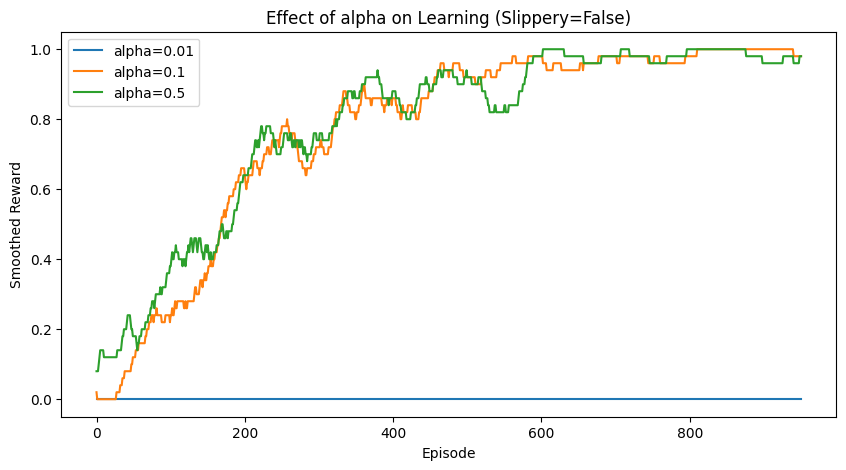

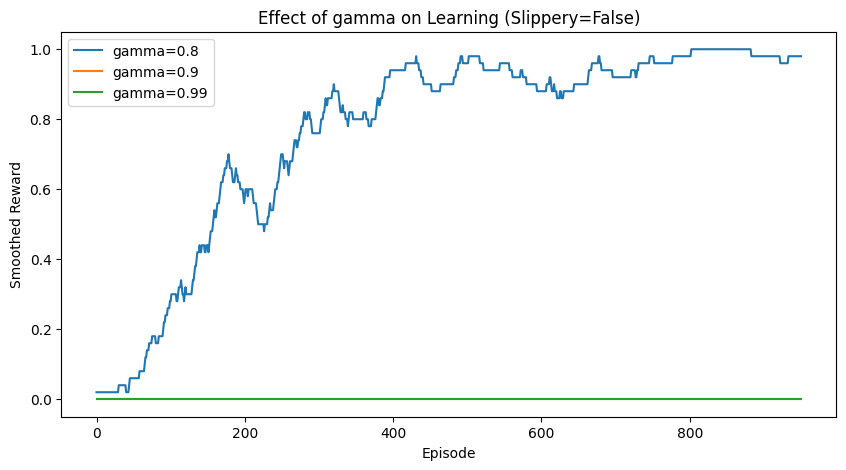

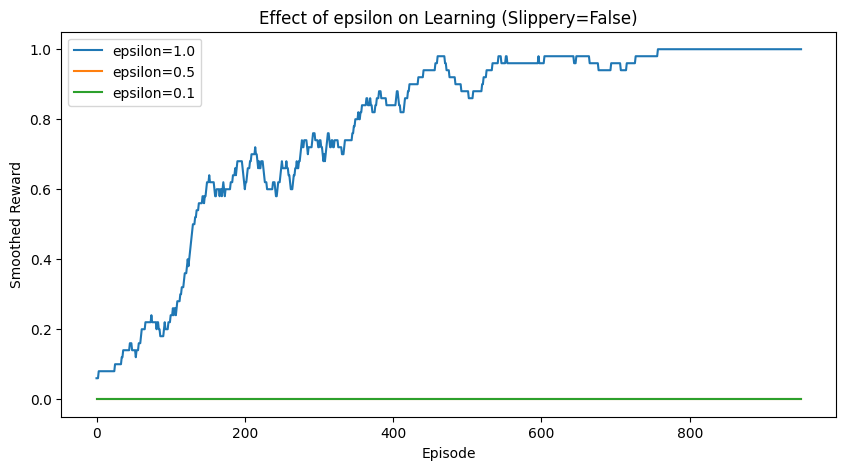

In [ ]:
# figures 1,2,3
def experiment_hyperparameters():
    env = create_env(is_slippery=False)
    settings = {
        "alpha": [0.01, 0.1, 0.5],
        "gamma": [0.8, 0.9, 0.99],
        "epsilon": [1.0, 0.5, 0.1]
    }

    for param, values in settings.items():
        plt.figure(figsize=(10, 5))
        for val in values:
            kwargs = {'alpha': 0.1, 'gamma': 0.9, 'epsilon': 1.0}
            kwargs[param] = val
            agent = QLearningAgent(env.observation_space.n, env.action_space.n, **kwargs)
            rewards = train_agent(env, agent)
            smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
            plt.plot(smoothed, label=f"{param}={val}")
        plt.title(f"Effect of {param} on Learning (Slippery=False)")
        plt.xlabel("Episode")
        plt.ylabel("Smoothed Reward")
        plt.legend()
        plt.show()

experiment_hyperparameters()
    

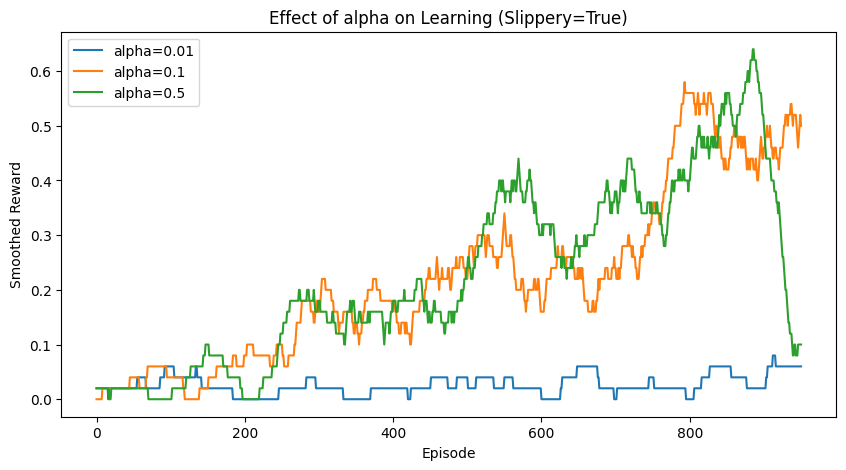

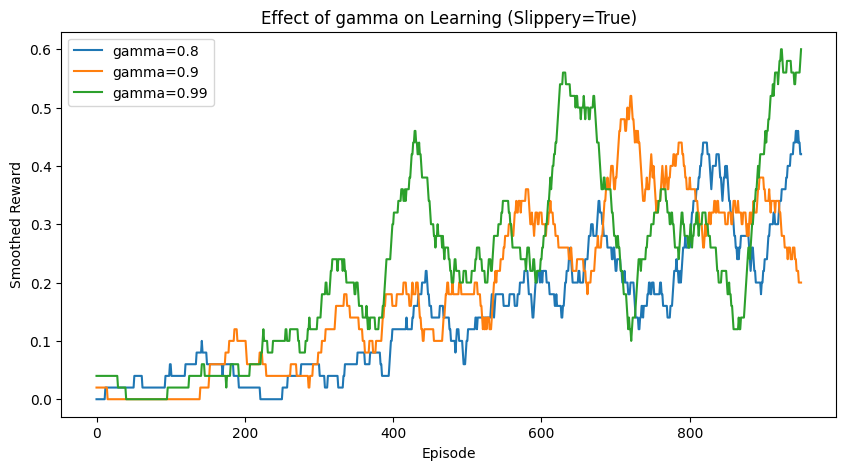

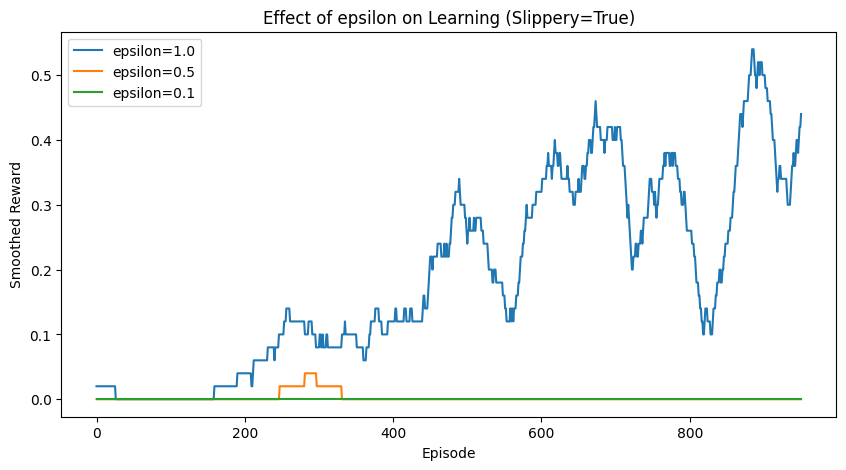

In [ ]:
# figures 4,5,6
def experiment_hyperparameters():
    env = create_env(is_slippery=True)
    settings = {
        "alpha": [0.01, 0.1, 0.5],
        "gamma": [0.8, 0.9, 0.99],
        "epsilon": [1.0, 0.5, 0.1]
    }

    for param, values in settings.items():
        plt.figure(figsize=(10, 5))
        for val in values:
            kwargs = {'alpha': 0.5, 'gamma': 0.9, 'epsilon': 1.0}
            kwargs[param] = val
            agent = QLearningAgent(env.observation_space.n, env.action_space.n, **kwargs)
            rewards = train_agent(env, agent)
            smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
            plt.plot(smoothed, label=f"{param}={val}")
        plt.title(f"Effect of {param} on Learning (Slippery=True)")
        plt.xlabel("Episode")
        plt.ylabel("Smoothed Reward")
        plt.legend()
        plt.show()

experiment_hyperparameters()
    

## 3. Exploration-Exploitation Trade-off

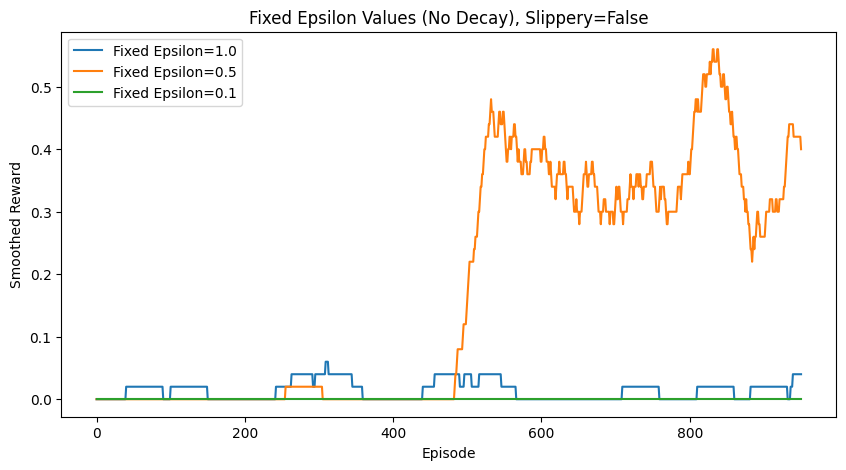

In [ ]:
# figure 7
def experiment_fixed_epsilon(epsilons=[1.0, 0.5, 0.1]):
    env = create_env(is_slippery=False)
    plt.figure(figsize=(10, 5))
    for eps in epsilons:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n, epsilon=eps, epsilon_decay=1.0)
        rewards = train_agent(env, agent)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Fixed Epsilon={eps}")
    plt.title("Fixed Epsilon Values (No Decay), Slippery=False")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

experiment_fixed_epsilon()
    

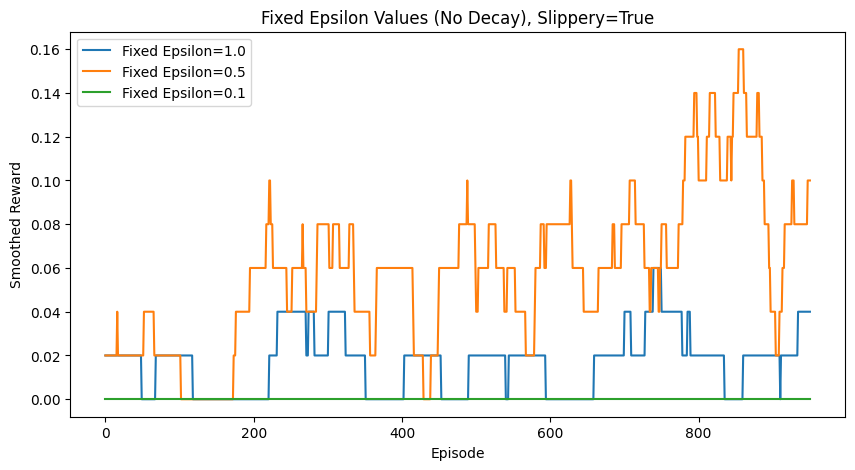

In [ ]:
# figure 10
def experiment_fixed_epsilon(epsilons=[1.0, 0.5, 0.1]):
    env = create_env(is_slippery=True)
    plt.figure(figsize=(10, 5))
    for eps in epsilons:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n, epsilon=eps, epsilon_decay=1.0)
        rewards = train_agent(env, agent)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Fixed Epsilon={eps}")
    plt.title("Fixed Epsilon Values (No Decay), Slippery=True")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

experiment_fixed_epsilon()

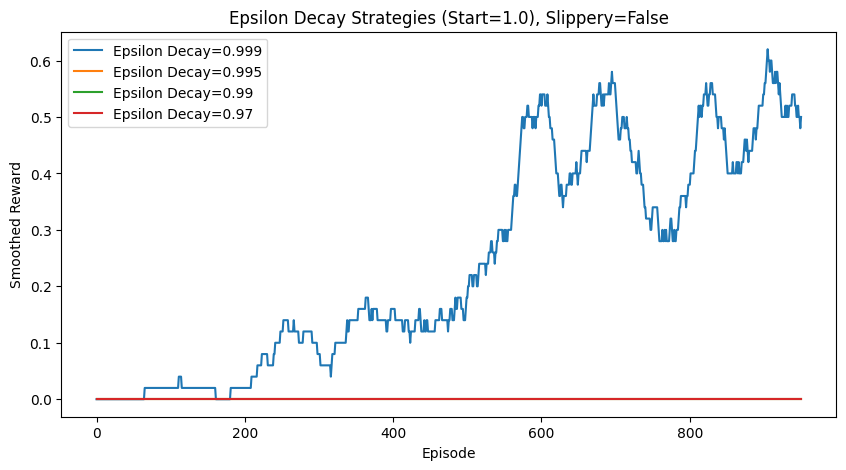

In [ ]:
# figure 8
def experiment_epsilon_decay(decays=[0.999, 0.995, 0.99, 0.97]):
    env = create_env(is_slippery=False)
    plt.figure(figsize=(10, 5))
    for decay in decays:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n, epsilon=1.0, epsilon_decay=decay)
        rewards = train_agent(env, agent)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Epsilon Decay={decay}")
    plt.title("Epsilon Decay Strategies (Start=1.0), Slippery=False")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

experiment_epsilon_decay()
    

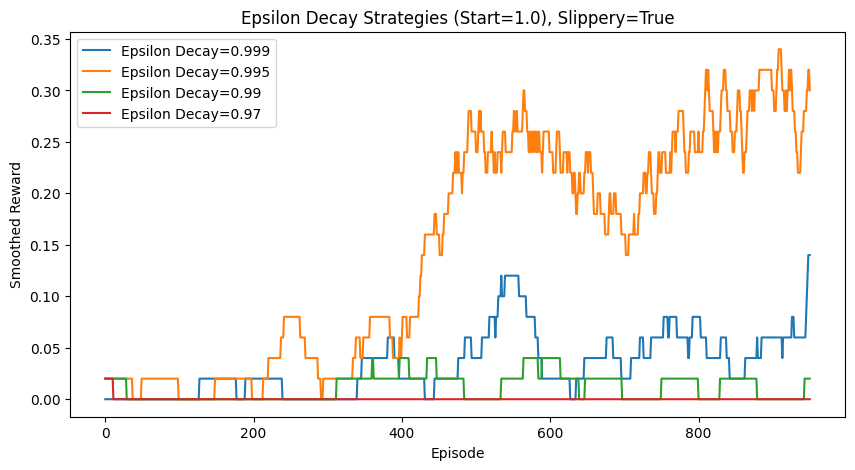

In [ ]:
# figure 11
def experiment_epsilon_decay(decays=[0.999, 0.995, 0.99, 0.97]):
    env = create_env(is_slippery=True)
    plt.figure(figsize=(10, 5))
    for decay in decays:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n, epsilon=1.0, epsilon_decay=decay)
        rewards = train_agent(env, agent)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Epsilon Decay={decay}")
    plt.title("Epsilon Decay Strategies (Start=1.0), Slippery=True")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

experiment_epsilon_decay()

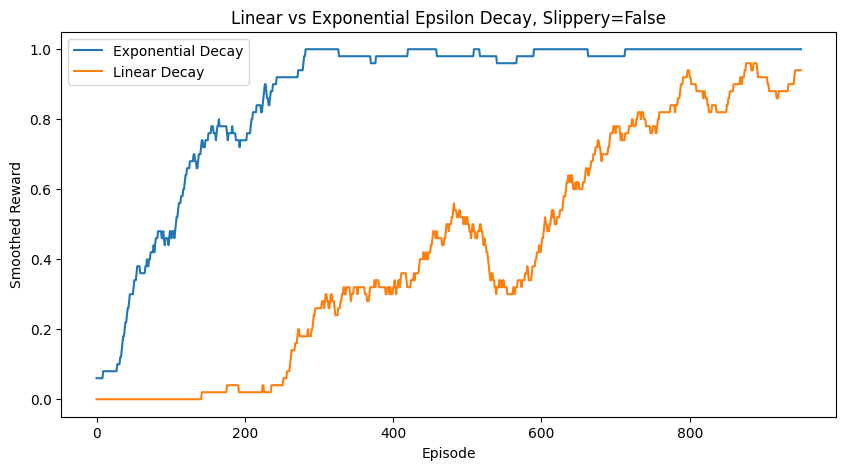

In [ ]:
# figure 9
def linear_decay(initial, min_eps, total_steps, step):
    return max(min_eps, initial - ((initial - min_eps) * step / total_steps))

def train_linear_decay(env, initial=1.0, min_eps=0.01, total_episodes=1000):
    agent = QLearningAgent(env.observation_space.n, env.action_space.n)
    rewards = []
    for ep in range(total_episodes):
        state, _ = env.reset()
        agent.epsilon = linear_decay(initial, min_eps, total_episodes, ep)
        total_reward = 0
        for _ in range(100):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return rewards

env = create_env(is_slippery=False)
exp_agent = QLearningAgent(env.observation_space.n, env.action_space.n, epsilon=1.0, epsilon_decay=0.99)
exp_rewards = train_agent(env, exp_agent)
lin_rewards = train_linear_decay(env)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(exp_rewards, np.ones(50)/50, mode='valid'), label="Exponential Decay")
plt.plot(np.convolve(lin_rewards, np.ones(50)/50, mode='valid'), label="Linear Decay")
plt.title("Linear vs Exponential Epsilon Decay, Slippery=False")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.show()
    

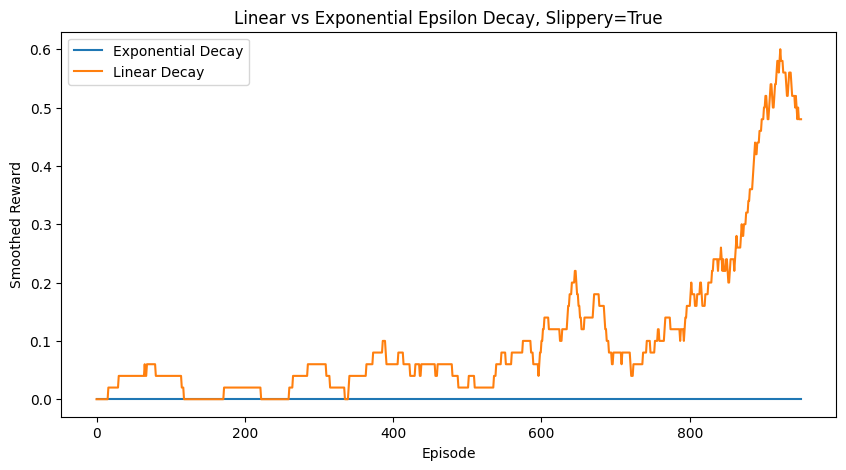

In [ ]:
# figure 12
env = create_env(is_slippery=True)
exp_agent = QLearningAgent(env.observation_space.n, env.action_space.n, epsilon=1.0, epsilon_decay=0.99)
exp_rewards = train_agent(env, exp_agent)
lin_rewards = train_linear_decay(env)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(exp_rewards, np.ones(50)/50, mode='valid'), label="Exponential Decay")
plt.plot(np.convolve(lin_rewards, np.ones(50)/50, mode='valid'), label="Linear Decay")
plt.title("Linear vs Exponential Epsilon Decay, Slippery=True")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.show()

## 4. Boltzmann vs Epsilon-Greedy

In [ ]:
def boltzmann_action(Q_state, temperature=1.0):
    q_vals = np.array(list(Q_state.values()))
    if temperature == 0:
        return np.argmax(q_vals)
    exp_q = np.exp(q_vals / temperature)
    probs = exp_q / np.sum(exp_q)
    return np.random.choice(len(q_vals), p=probs)
    

In [ ]:
def train_boltzmann(env, temperature=1.0, episodes=1000, max_steps=100):
    n_states = env.observation_space.n
    n_actions = env.action_space.n
    Q = defaultdict(lambda: {a: 0.0 for a in range(n_actions)})
    rewards = []

    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_steps):
            if Q[state]:
                action = boltzmann_action(Q[state], temperature)
            else:
                action = np.random.randint(n_actions)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            max_next_q = max(Q[next_state].values()) if not done else 0.0
            td_target = reward + 0.99 * max_next_q
            td_error = td_target - Q[state][action]
            Q[state][action] += 0.1 * td_error
            state = next_state
            total_reward += reward
            if done:
                break
        rewards.append(total_reward)
    return rewards
    

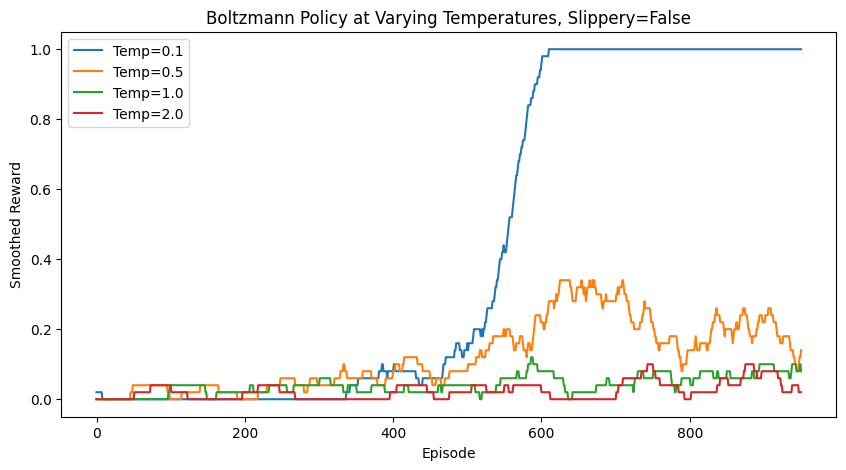

In [ ]:
# figure 13
def experiment_boltzmann_temperatures(temperatures=[0.1, 0.5, 1.0, 2.0]):
    env = create_env(is_slippery=False)
    plt.figure(figsize=(10, 5))
    for temp in temperatures:
        rewards = train_boltzmann(env, temperature=temp)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Temp={temp}")
    plt.title("Boltzmann Policy at Varying Temperatures, Slippery=False")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

experiment_boltzmann_temperatures()
    

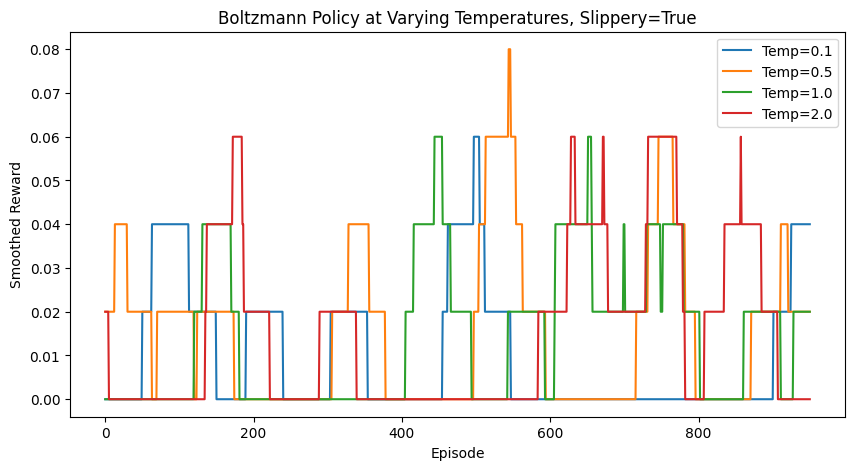

In [ ]:
# figure 15
def experiment_boltzmann_temperatures_s(temperatures=[0.1, 0.5, 1.0, 2.0]):
    env = create_env(is_slippery=True)
    plt.figure(figsize=(10, 5))
    for temp in temperatures:
        rewards = train_boltzmann(env, temperature=temp)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Temp={temp}")
    plt.title("Boltzmann Policy at Varying Temperatures, Slippery=True")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

experiment_boltzmann_temperatures_s()

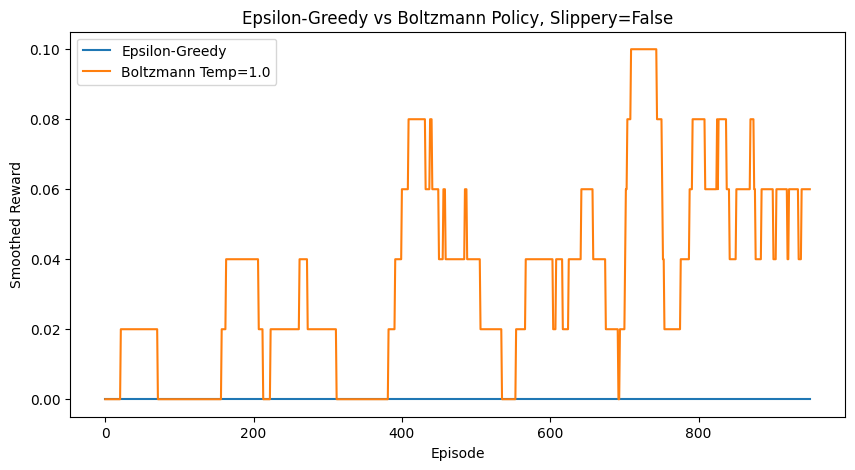

In [ ]:
# figure 14
env = create_env(is_slippery=False)
eps_agent = QLearningAgent(env.observation_space.n, env.action_space.n)

eps_rewards = train_agent(env, eps_agent)
boltz_rewards = train_boltzmann(env, temperature=1.0)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(eps_rewards, np.ones(50)/50, mode='valid'), label="Epsilon-Greedy")
plt.plot(np.convolve(boltz_rewards, np.ones(50)/50, mode='valid'), label="Boltzmann Temp=1.0")
plt.title("Epsilon-Greedy vs Boltzmann Policy, Slippery=False")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.show()
    

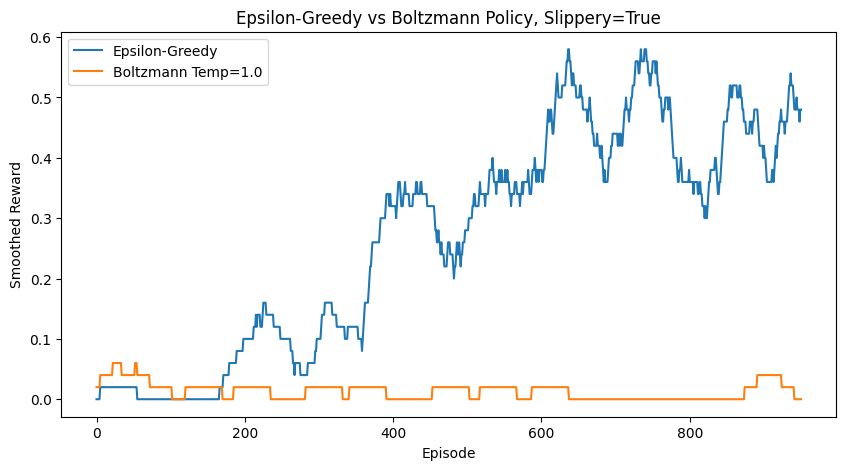

In [ ]:
# figure 16
env = create_env(is_slippery=True)
eps_agent = QLearningAgent(env.observation_space.n, env.action_space.n)

eps_rewards = train_agent(env, eps_agent)
boltz_rewards = train_boltzmann(env, temperature=1.0)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(eps_rewards, np.ones(50)/50, mode='valid'), label="Epsilon-Greedy")
plt.plot(np.convolve(boltz_rewards, np.ones(50)/50, mode='valid'), label="Boltzmann Temp=1.0")
plt.title("Epsilon-Greedy vs Boltzmann Policy, Slippery=True")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.show()

## 5. Resulting Policy

In [ ]:
# figure 17,18,19
best_config_d = {
    "alpha": 0.01,
    "gamma": 0.8,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "epsilon_min": 0.1
}

best_config_s = {
    "alpha": 0.5,
    "gamma": 0.9,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "epsilon_min": 0.1
}

env = create_env(is_slippery=False)
agent = QLearningAgent(env.observation_space.n, env.action_space.n, **best_config_d)
train_agent(env, agent)

display_policy(agent.Q, shape=(4, 4), title="Final Policy (Deterministic Environment)")
print_q_table(agent.Q, shape=(4, 4))

env_slip = create_env(is_slippery=True)
agent_slip = QLearningAgent(env_slip.observation_space.n, env_slip.action_space.n, **best_config_s)
train_agent(env_slip, agent_slip)

display_policy(agent_slip.Q, shape=(4, 4), title="Final Policy (Stochastic Environment)")
print_q_table(agent_slip.Q, shape=(4, 4))


Final Policy (Deterministic Environment)
[['←' '←' '←' '←']
 ['←' '←' '←' '←']
 ['←' '←' '←' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.00 | 0.00
Final Policy (Stochastic Environment)
[['←' '↑' '←' '↑']
 ['←' '←' '←' '←']
 ['↓' '↓' '↓' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.08 | 0.06 | 0.09 | 0.07
0.13 | 0.00 | 0.10 | 0.00
0.23 | 0.25 | 0.26 | 0.00
0.00 | 0.37 | 0.66 | 0.00


In [1217]:
env_video_d = create_env(is_slippery=False, render_mode="rgb_array")
video_path_d = record_video(env_video_d, agent.Q, path="frozenlake_deterministic.mp4")
Video(video_path_d)


In [1218]:
env_video_s = create_env(is_slippery=True, render_mode="rgb_array")
video_path_s = record_video(env_video_s, agent_slip.Q, path="frozenlake_stochastic.mp4")
Video(video_path_s)

## 6. Reward Shaping and Negative Penalties

In [1219]:
def train_with_penalties(env, agent, step_penalty=-0.002, hole_penalty=-1.0, episodes=1000, max_steps=100):
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_steps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if done:
                if reward == 0:
                    reward = hole_penalty 
            elif reward == 0:
                reward = step_penalty  

            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break

        agent.decay_epsilon()
        rewards.append(total_reward)
    return rewards


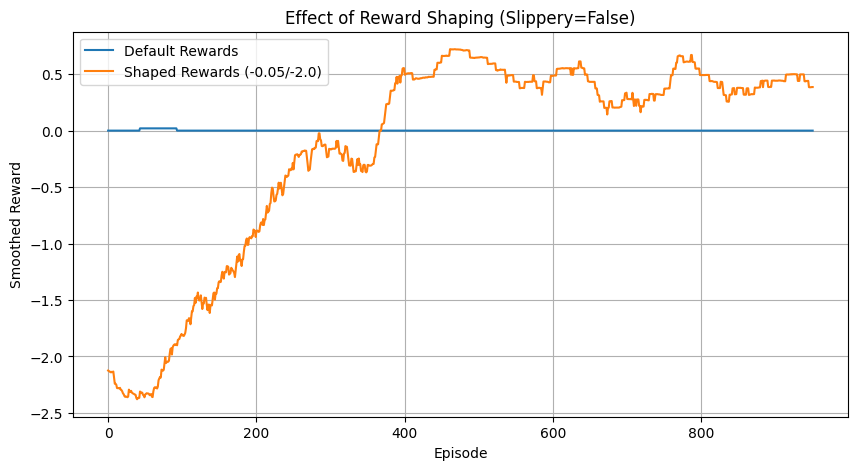

In [ ]:
# figure 20
env_d = create_env(is_slippery=False)
agent_default_d = QLearningAgent(env_d.observation_space.n, env_d.action_space.n, **best_config_d)
agent_penalty_d = QLearningAgent(env_d.observation_space.n, env_d.action_space.n, **best_config_d)

rewards_default_d = train_agent(env_d, agent_default_d)
rewards_penalty_d = train_with_penalties(env_d, agent_penalty_d, step_penalty=-0.05, hole_penalty=-2.0)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards_default_d, np.ones(50)/50, mode='valid'), label="Default Rewards")
plt.plot(np.convolve(rewards_penalty_d, np.ones(50)/50, mode='valid'), label="Shaped Rewards (-0.05/-2.0)")
plt.title("Effect of Reward Shaping (Slippery=False)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.show()

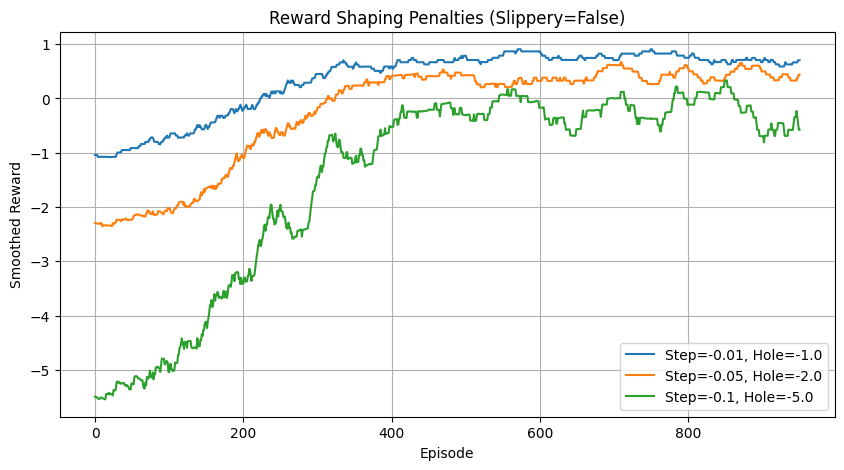

In [ ]:
# figure 21
def experiment_penalties_deterministic():
    env = create_env(is_slippery=False)
    penalties = [(-0.01, -1.0), (-0.05, -2.0), (-0.1, -5.0)]

    plt.figure(figsize=(10, 5))
    for step_p, hole_p in penalties:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n, **best_config_d)
        rewards = train_with_penalties(env, agent, step_penalty=step_p, hole_penalty=hole_p)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Step={step_p}, Hole={hole_p}")

    plt.title("Reward Shaping Penalties (Slippery=False)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

experiment_penalties_deterministic()

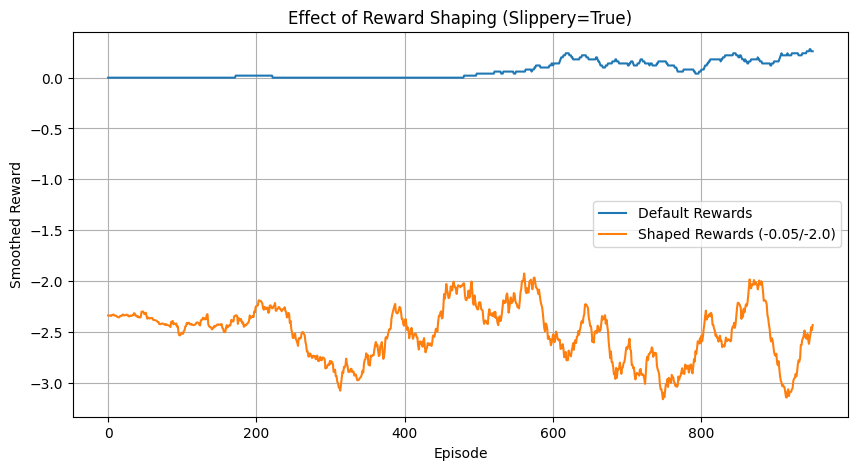

In [ ]:
# figure 24
env_s = create_env(is_slippery=True)
agent_default_s = QLearningAgent(env_s.observation_space.n, env_s.action_space.n, **best_config_s)
agent_penalty_s = QLearningAgent(env_s.observation_space.n, env_s.action_space.n, **best_config_s)

rewards_default_s = train_agent(env_s, agent_default_s)
rewards_penalty_s = train_with_penalties(env_s, agent_penalty_s, step_penalty=-0.05, hole_penalty=-2.0)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards_default_s, np.ones(50)/50, mode='valid'), label="Default Rewards")
plt.plot(np.convolve(rewards_penalty_s, np.ones(50)/50, mode='valid'), label="Shaped Rewards (-0.05/-2.0)")
plt.title("Effect of Reward Shaping (Slippery=True)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.show()


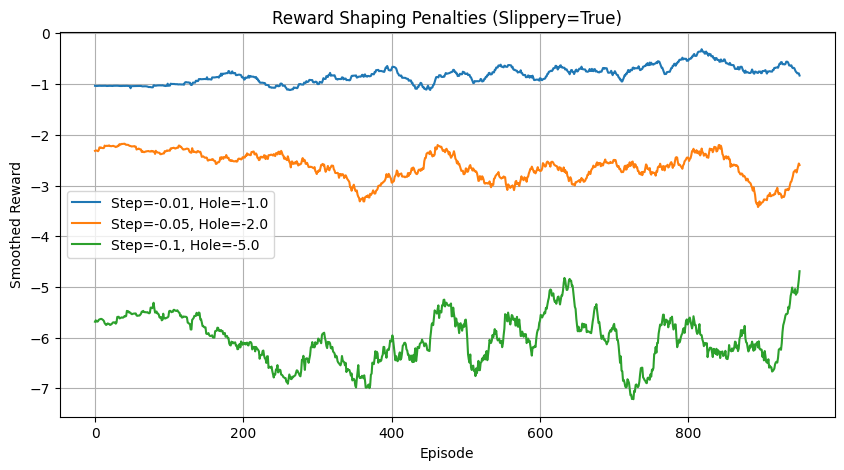

In [ ]:
# figure 25
def experiment_penalties_stochastic():
    env = create_env(is_slippery=True)
    penalties = [(-0.01, -1.0), (-0.05, -2.0), (-0.1, -5.0)]

    plt.figure(figsize=(10, 5))
    for step_p, hole_p in penalties:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n, **best_config_s)
        rewards = train_with_penalties(env, agent, step_penalty=step_p, hole_penalty=hole_p)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Step={step_p}, Hole={hole_p}")

    plt.title("Reward Shaping Penalties (Slippery=True)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.grid(True)
    plt.show()

experiment_penalties_stochastic()


In [ ]:
# figure 22
display_policy(agent_penalty_d.Q, shape=(4, 4), title="Policy After Shaping (Slippery=False)")
print_q_table(agent_penalty_d.Q, shape=(4, 4))

env_video_d = create_env(is_slippery=False, render_mode="rgb_array")
video_path_d = record_video(env_video_d, agent_penalty_d.Q, path="reward_shaping_d.mp4")
Video(video_path_d)

Policy After Shaping (Slippery=False)
[['→' '→' '↓' '←']
 ['↓' '←' '↓' '←']
 ['→' '→' '↓' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.07 | 0.20 | 0.35 | -0.01
-0.06 | 0.00 | 0.53 | 0.00
0.03 | 0.28 | 0.75 | 0.00
0.00 | 0.18 | 1.00 | 0.00


In [ ]:
# figure 26
display_policy(agent_penalty_s.Q, shape=(4, 4), title="Policy After Shaping (Slippery=True)")
print_q_table(agent_penalty_s.Q, shape=(4, 4))

env_video_s = create_env(is_slippery=True, render_mode="rgb_array")
video_path_s = record_video(env_video_s, agent_penalty_s.Q, path="reward_shaping_s.mp4")
Video(video_path_s)


Policy After Shaping (Slippery=True)
[['→' '↑' '↑' '↑']
 ['←' '←' '←' '←']
 ['↑' '↓' '←' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
-0.43 | -0.47 | -0.49 | -0.49
-0.34 | 0.00 | -0.99 | 0.00
-0.21 | 0.05 | 0.22 | 0.00
0.00 | 0.54 | 0.94 | 0.00


In [1226]:
def plot_average_rewards(reward_dict, title="Average Reward per Episode", smoothing=50):
    plt.figure(figsize=(10, 5))
    for label, rewards in reward_dict.items():
        smoothed = np.convolve(rewards, np.ones(smoothing)/smoothing, mode='valid')
        plt.plot(smoothed, label=label)
    plt.title(f"{title}")
    plt.xlabel("Episode")
    plt.ylabel("Average Reward")
    plt.legend()
    plt.grid(True)
    plt.show()


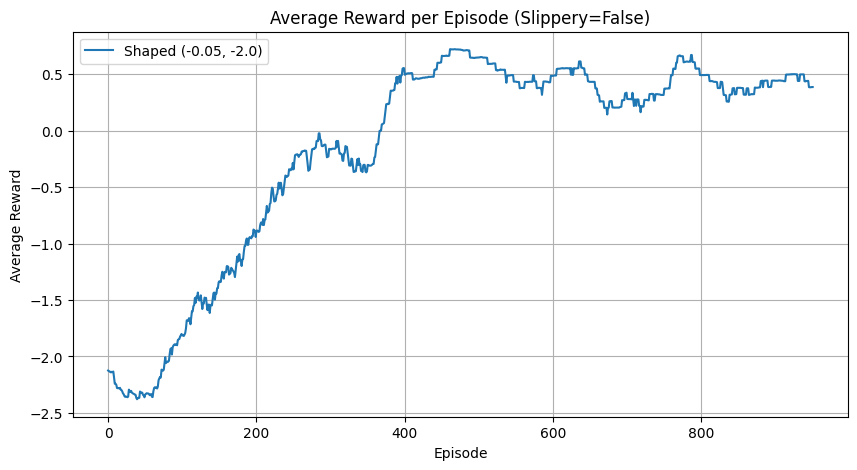

In [ ]:
# figure 23
reward_dict_d = {
    "Shaped (-0.05, -2.0)": rewards_penalty_d
}

plot_average_rewards(reward_dict_d, title="Average Reward per Episode (Slippery=False)")


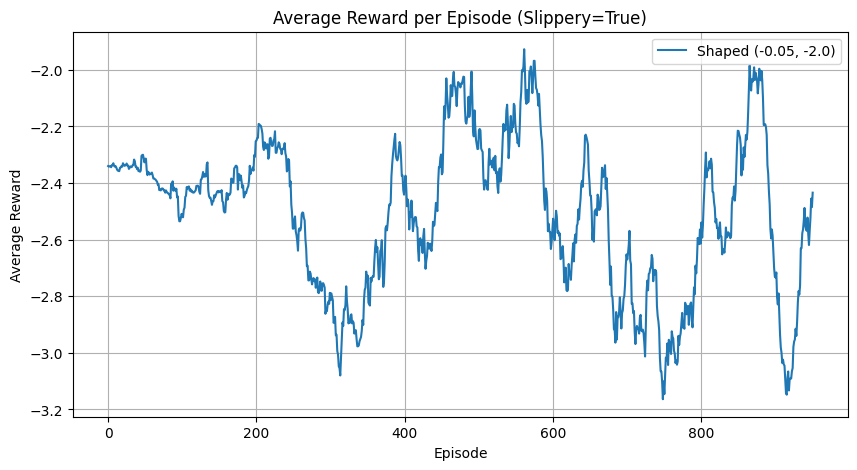

In [ ]:
# figure 27
reward_dict_s = {
    "Shaped (-0.05, -2.0)": rewards_penalty_s
}

plot_average_rewards(reward_dict_s, title="Average Reward per Episode (Slippery=True)")

## 7. Stochastic vs Deterministic Environment

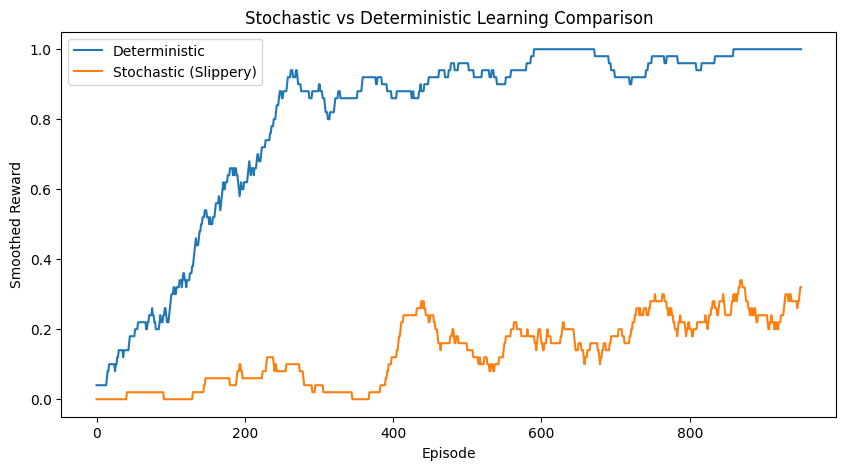

Deterministic Policy:
Policy (Deterministic)
[['↓' '←' '←' '←']
 ['↓' '←' '←' '←']
 ['→' '↓' '↓' '']
 ['' '' '' '']]
Stochastic Policy:
Policy (Stochastic)
[['←' '←' '←' '←']
 ['←' '←' '↓' '←']
 ['↑' '→' '←' '']
 ['' '' '' '']]
Q-Table (Deterministic):
Q-Table (max Q-values per state):
0.95 | 0.82 | 0.20 | 0.00
0.96 | 0.00 | 0.00 | 0.00
0.97 | 0.98 | 0.97 | 0.00
0.00 | 0.99 | 1.00 | 0.00
Q-Table (Stochastic):
Q-Table (max Q-values per state):
0.23 | 0.07 | 0.00 | 0.00
0.24 | 0.00 | 0.13 | 0.00
0.25 | 0.29 | 0.44 | 0.00
0.00 | 0.38 | 0.79 | 0.00


In [ ]:
# figure 28,29
def compare_slippery_behavior(episodes=1000):
    env_stochastic = create_env(is_slippery=True)
    env_deterministic = create_env(is_slippery=False)

    agent_stoch = QLearningAgent(env_stochastic.observation_space.n, env_stochastic.action_space.n)
    agent_determ = QLearningAgent(env_deterministic.observation_space.n, env_deterministic.action_space.n)

    rewards_stoch = train_agent(env_stochastic, agent_stoch, episodes=episodes)
    rewards_determ = train_agent(env_deterministic, agent_determ, episodes=episodes)

    plt.figure(figsize=(10, 5))
    plt.plot(np.convolve(rewards_determ, np.ones(50)/50, mode='valid'), label="Deterministic")
    plt.plot(np.convolve(rewards_stoch, np.ones(50)/50, mode='valid'), label="Stochastic (Slippery)")
    plt.title("Stochastic vs Deterministic Learning Comparison")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

    # Visualize resulting policies
    print("Deterministic Policy:")
    display_policy(agent_determ.Q, shape=(4, 4), title="Policy (Deterministic)")

    print("Stochastic Policy:")
    display_policy(agent_stoch.Q, shape=(4, 4), title="Policy (Stochastic)")

    print("Q-Table (Deterministic):")
    print_q_table(agent_determ.Q, shape=(4, 4))

    print("Q-Table (Stochastic):")
    print_q_table(agent_stoch.Q, shape=(4, 4))
    
compare_slippery_behavior()
    

## 8. Craving Behaviour: Q-Value Heatmap with Optimal Arrows

In [1245]:
def plot_craving_behavior(Q, shape=(4, 4), title="Q-Values and Craving Behavior", show_arrows=True, show_values=True):
    q_matrix = np.zeros(shape)
    arrows_matrix = np.full(shape, '', dtype=object)
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}

    for s in range(shape[0] * shape[1]):
        row, col = divmod(s, shape[1])
        if Q[s]:
            best_action = max(Q[s], key=Q[s].get)
            q_matrix[row, col] = max(Q[s].values()) if show_values else 0
            arrows_matrix[row, col] = arrows[best_action] if show_arrows else ""

    plt.figure(figsize=(6, 5))
    ax = sns.heatmap(q_matrix, annot=arrows_matrix, fmt='', cmap="YlGnBu", cbar=show_values, linewidths=0.5, linecolor='gray')
    plt.title(f"{title}")
    plt.xlabel("Column")
    plt.ylabel("Row")
    plt.show()

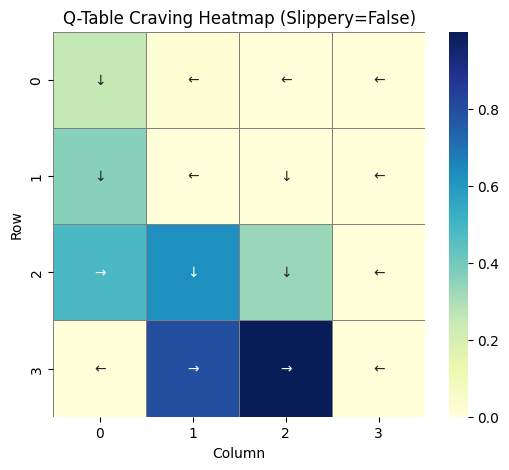

In [ ]:
# figure 30
env_d = create_env(is_slippery=False)
agent_d = QLearningAgent(env_d.observation_space.n, env_d.action_space.n, **best_config_d)
train_agent(env_d, agent_d)

plot_craving_behavior(agent_d.Q, title="Q-Table Craving Heatmap (Slippery=False)")


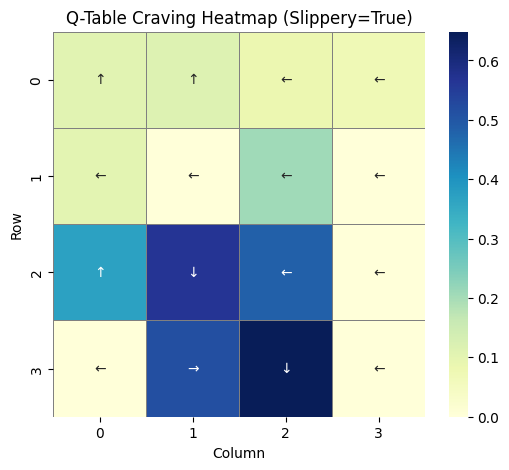

In [ ]:
# figure 31
env_s = create_env(is_slippery=True)
agent_s = QLearningAgent(env_s.observation_space.n, env_s.action_space.n, **best_config_s)
train_agent(env_s, agent_s)

plot_craving_behavior(agent_s.Q, title="Q-Table Craving Heatmap (Slippery=True)")

## 9. Experience Replay

In [1249]:
class ReplayAgent(QLearningAgent):
    def __init__(self, *args, buffer_size=10000, batch_size=64, **kwargs):
        super().__init__(*args, **kwargs)
        self.replay_buffer = []
        self.buffer_size = buffer_size
        self.batch_size = batch_size

    def store(self, state, action, reward, next_state, done):
        if len(self.replay_buffer) >= self.buffer_size:
            self.replay_buffer.pop(0)
        self.replay_buffer.append((state, action, reward, next_state, done))

    def replay(self):
        if len(self.replay_buffer) < self.batch_size:
            return
        batch = random.sample(self.replay_buffer, self.batch_size)
        for state, action, reward, next_state, done in batch:
            max_next_q = max(self.Q[next_state].values()) if not done else 0.0
            td_target = reward + self.gamma * max_next_q
            td_error = td_target - self.Q[state][action]
            self.Q[state][action] += self.alpha * td_error

In [1250]:
def train_with_replay(env, agent, episodes=1000, max_steps=100):
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_steps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            agent.store(state, action, reward, next_state, done)
            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        agent.replay() 
        agent.decay_epsilon()
        rewards.append(total_reward)
    return rewards


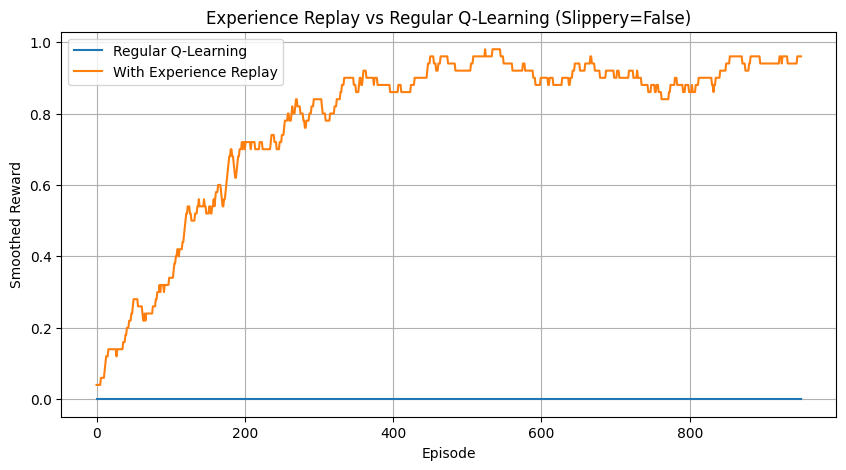

In [ ]:
# figure 32
env = create_env(is_slippery=False)

best_config = {
    "alpha": 0.01,
    "gamma": 0.8,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "epsilon_min": 0.1
}

baseline_agent = QLearningAgent(env.observation_space.n, env.action_space.n, **best_config)
replay_agent = ReplayAgent(env.observation_space.n, env.action_space.n, **best_config)

rewards_baseline = train_agent(env, baseline_agent)
rewards_replay = train_with_replay(env, replay_agent)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards_baseline, np.ones(50)/50, mode='valid'), label="Regular Q-Learning")
plt.plot(np.convolve(rewards_replay, np.ones(50)/50, mode='valid'), label="With Experience Replay")
plt.title("Experience Replay vs Regular Q-Learning (Slippery=False)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# figure 33
display_policy(replay_agent.Q, shape=(4, 4), title="Policy (With Experience Replay)")
print_q_table(replay_agent.Q, shape=(4, 4))

Policy (With Experience Replay)
[['→' '→' '↓' '←']
 ['↓' '←' '↓' '←']
 ['→' '→' '↓' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.33 | 0.41 | 0.51 | 0.41
0.41 | 0.00 | 0.64 | 0.00
0.51 | 0.64 | 0.80 | 0.00
0.00 | 0.79 | 1.00 | 0.00


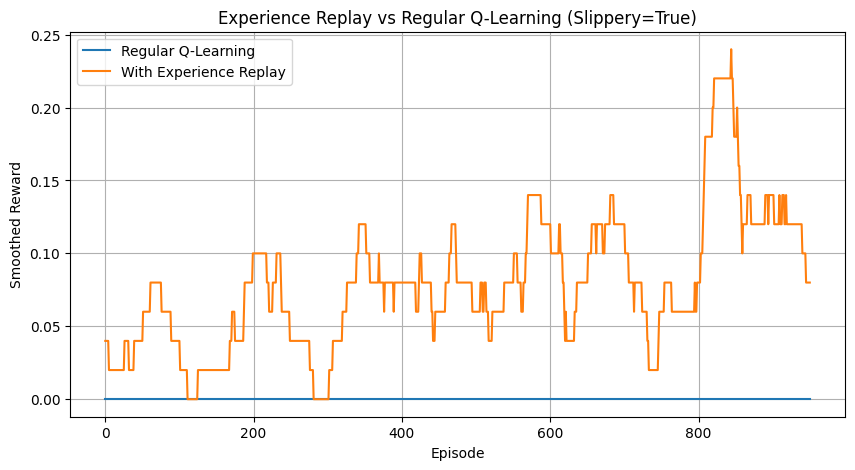

In [ ]:
# figure 34
env_s = create_env(is_slippery=True)

best_config_s = {
    "alpha": 0.5,
    "gamma": 0.9,
    "epsilon": 0.5,
    "epsilon_decay": 0.995,
    "epsilon_min": 0.1
}

baseline_agent_s = QLearningAgent(env_s.observation_space.n, env_s.action_space.n, **best_config_s)
replay_agent_s = ReplayAgent(env_s.observation_space.n, env_s.action_space.n, **best_config_s)

rewards_baseline_s = train_agent(env_s, baseline_agent_s)
rewards_replay_s = train_with_replay(env_s, replay_agent_s)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards_baseline_s, np.ones(50)/50, mode='valid'), label="Regular Q-Learning")
plt.plot(np.convolve(rewards_replay_s, np.ones(50)/50, mode='valid'), label="With Experience Replay")
plt.title("Experience Replay vs Regular Q-Learning (Slippery=True)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# figure 35
display_policy(replay_agent_s.Q, shape=(4, 4), title="Policy (Replay Agent, Slippery=True)")
print_q_table(replay_agent_s.Q, shape=(4, 4))

Policy (Replay Agent, Slippery=True)
[['→' '→' '↓' '↑']
 ['←' '←' '←' '←']
 ['↓' '↓' '←' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.21 | 0.22 | 0.29 | 0.25
0.21 | 0.00 | 0.19 | 0.00
0.26 | 0.47 | 0.53 | 0.00
0.00 | 0.64 | 0.75 | 0.00


## 10. Injected Trajectories

In [1273]:
def inject_trajectory(agent, trajectory, gamma=0.99):
    for i, (state, action, reward, next_state, done) in enumerate(trajectory):
        discount = gamma ** i
        agent.Q[state][action] += discount * reward
    return agent
    

In [1274]:
trajectory = [
    (0, 2, 0, 1, False),
    (1, 2, 0, 2, False),
    (2, 2, 0, 3, False),
    (3, 1, 0, 7, False),
    (7, 1, 0, 11, False),
    (11, 2, 1, 15, True)
]
    

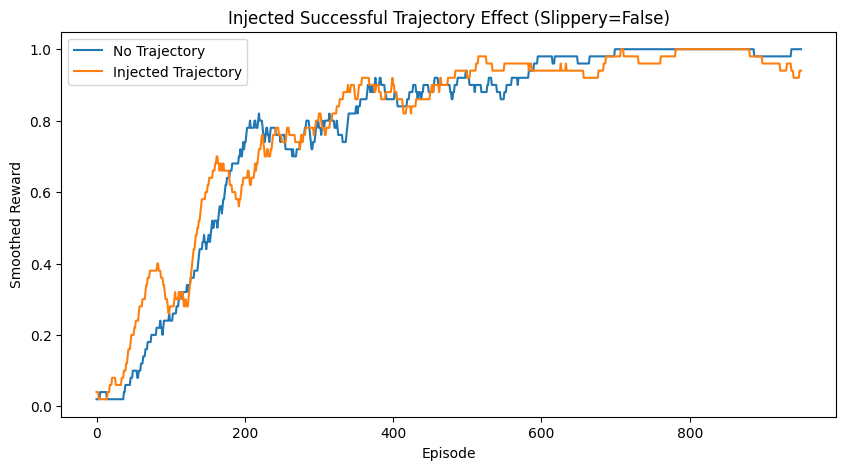

In [ ]:
# figure 36
env = create_env(is_slippery=False)
agent_normal = QLearningAgent(env.observation_space.n, env.action_space.n)
agent_injected = QLearningAgent(env.observation_space.n, env.action_space.n)

inject_trajectory(agent_injected, trajectory)

rewards_normal = train_agent(env, agent_normal)
rewards_injected = train_agent(env, agent_injected)

plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards_normal, np.ones(50)/50, mode='valid'), label="No Trajectory")
plt.plot(np.convolve(rewards_injected, np.ones(50)/50, mode='valid'), label="Injected Trajectory")
plt.title("Injected Successful Trajectory Effect (Slippery=False)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.show()
    

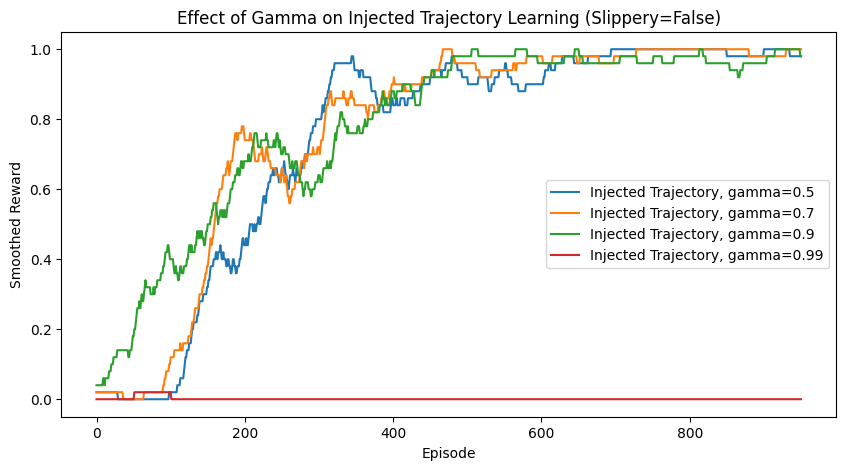

In [ ]:
# figure 37
def test_injection_with_gammas(gammas=[0.5, 0.7, 0.9, 0.99]):
    env = create_env(is_slippery=False)
    plt.figure(figsize=(10, 5))
    for g in gammas:
        agent = QLearningAgent(env.observation_space.n, env.action_space.n)
        inject_trajectory(agent, trajectory, gamma=g)
        rewards = train_agent(env, agent)
        smoothed = np.convolve(rewards, np.ones(50)/50, mode='valid')
        plt.plot(smoothed, label=f"Injected Trajectory, gamma={g}")
    plt.title("Effect of Gamma on Injected Trajectory Learning (Slippery=False)")
    plt.xlabel("Episode")
    plt.ylabel("Smoothed Reward")
    plt.legend()
    plt.show()

test_injection_with_gammas()
    

## 11. Comprehensive Perfomance Comparison

In [1323]:
env = create_env(is_slippery=False)
shape = (4, 4)

In [1324]:
eg_agent = QLearningAgent(env.observation_space.n, env.action_space.n, **best_config_d)
eg_rewards = train_agent(env, eg_agent)

In [1325]:
boltz_rewards = train_boltzmann(env, temperature=1.0)

In [1326]:
penalty_agent = QLearningAgent(env.observation_space.n, env.action_space.n, **best_config_d)
penalty_rewards = train_with_penalties(env, penalty_agent, step_penalty=-0.05, hole_penalty=-2.0)

In [1327]:
replay_agent = ReplayAgent(env.observation_space.n, env.action_space.n, **best_config_d)
replay_rewards = train_with_replay(env, replay_agent)

In [1328]:
inject_agent = QLearningAgent(env.observation_space.n, env.action_space.n, **best_config_d)

trajectory = [
    (0, 2, 0, 1, False),
    (1, 2, 0, 2, False),
    (2, 2, 0, 3, False),
    (3, 1, 0, 7, False),
    (7, 1, 0, 11, False),
    (11, 2, 1, 15, True)
]

inject_trajectory(inject_agent, trajectory)
inject_rewards = train_agent(env, inject_agent)

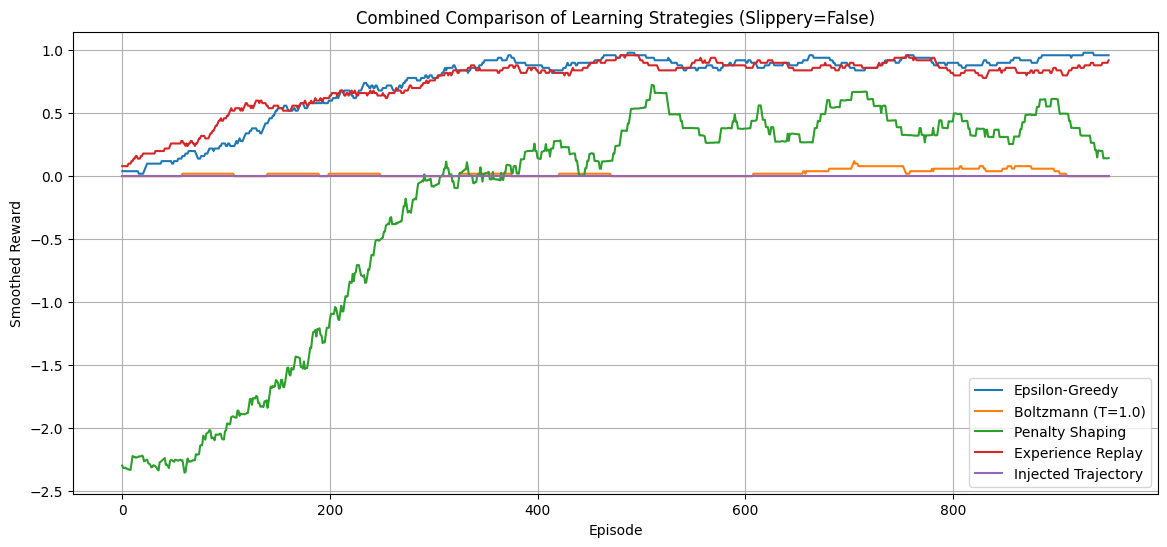

In [ ]:
# figure 38
plt.figure(figsize=(14, 6))
plt.plot(np.convolve(eg_rewards, np.ones(50)/50, mode='valid'), label="Epsilon-Greedy")
plt.plot(np.convolve(boltz_rewards, np.ones(50)/50, mode='valid'), label="Boltzmann (T=1.0)")
plt.plot(np.convolve(penalty_rewards, np.ones(50)/50, mode='valid'), label="Penalty Shaping")
plt.plot(np.convolve(replay_rewards, np.ones(50)/50, mode='valid'), label="Experience Replay")
plt.plot(np.convolve(inject_rewards, np.ones(50)/50, mode='valid'), label="Injected Trajectory")
plt.title("Combined Comparison of Learning Strategies (Slippery=False)")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.show()


In [1330]:
def evaluate_agent(Q, title, shape=(4, 4)):
    display_policy(Q, shape=shape, title=f"Policy: {title}")
    print_q_table(Q, shape=shape)

evaluate_agent(eg_agent.Q, "Epsilon-Greedy")
evaluate_agent(penalty_agent.Q, "Reward Shaping")
evaluate_agent(replay_agent.Q, "Experience Replay")
evaluate_agent(inject_agent.Q, "Injected Trajectory")

Policy: Epsilon-Greedy
[['↓' '→' '↓' '←']
 ['↓' '←' '↓' '←']
 ['→' '→' '↓' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.26 | 0.00 | 0.01 | 0.00
0.36 | 0.00 | 0.21 | 0.00
0.48 | 0.63 | 0.80 | 0.00
0.00 | 0.26 | 1.00 | 0.00
Policy: Reward Shaping
[['→' '→' '↓' '←']
 ['↓' '←' '↓' '←']
 ['→' '→' '↓' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.06 | 0.19 | 0.35 | -0.01
-0.06 | 0.00 | 0.53 | 0.00
0.03 | 0.27 | 0.74 | 0.00
0.00 | 0.14 | 1.00 | 0.00
Policy: Experience Replay
[['↓' '→' '↓' '←']
 ['↓' '←' '↓' '←']
 ['→' '→' '↓' '']
 ['' '' '' '']]
Q-Table (max Q-values per state):
0.33 | 0.41 | 0.51 | 0.25
0.41 | 0.00 | 0.64 | 0.00
0.51 | 0.64 | 0.80 | 0.00
0.00 | 0.80 | 1.00 | 0.00
Policy: Injected Trajectory
[['←' '←' '←' '←']
 ['←' '←' '←' '←']
 ['←' '←' '←' '→']
 ['←' '' '' '']]
Q-Table (max Q-values per state):
0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.00 | 0.00
0.00 | 0.00 | 0.00 | 0.95
0.00 | 0.00 | 0.00 | 0.00


## 12. Scaling up to Larger FrozenLake Maps

In [1613]:
# def create_large_env(map_size=8, is_slippery=False, render_mode=None):
#     if map_size == 4:
#         return gym.make("FrozenLake-v1", map_name="4x4", is_slippery=is_slippery, render_mode=render_mode)
#     elif map_size == 8:
#         return gym.make("FrozenLake-v1", map_name="8x8", is_slippery=is_slippery, render_mode=render_mode)
#     elif map_size == 16:
#         desc = np.full((16, 16), '.', dtype='U1')
#         desc[0, 0] = 'S'
#         desc[15, 15] = 'G'

#         safe_path = [(i, 0) for i in range(16)] + [(15, j) for j in range(1, 16)]

#         np.random.seed(42)
#         all_positions = [(i, j) for i in range(16) for j in range(16)]
#         hole_candidates = [pos for pos in all_positions if pos not in safe_path and pos != (0, 0) and pos != (15, 15)]

#         hole_indices = np.random.choice(len(hole_candidates), size=60, replace=False)
#         for idx in hole_indices:
#             r, c = hole_candidates[idx]
#             desc[r, c] = 'H'

#         return gym.make("FrozenLake-v1", desc=["".join(row) for row in desc], is_slippery=is_slippery, render_mode=render_mode)

#     else:
#         raise ValueError("Only 4, 8, or 16 supported.")


In [ ]:
def create_large_env(map_size=8, is_slippery=False, render_mode=None):
    if map_size == 4:
        return gym.make("FrozenLake-v1", map_name="4x4", is_slippery=is_slippery, render_mode=render_mode)
    elif map_size == 8:
        return gym.make("FrozenLake-v1", map_name="8x8", is_slippery=is_slippery, render_mode=render_mode)
    elif map_size == 16:
        desc = [
            "S.H...H....H....",
            ".H.HH...H.HH....",
            "....H.......H...",
            ".HH..HH..H.H....",
            "...H.....H.H.H..",
            "....HH.H........",
            "...H.....H......",
            "HHH..H.H..H.HHH.",
            ".....H.....H....",
            "...HH..H..HH....",
            ".H..H.....H.H...",
            ".....H.H..H..H..",
            ".H.H....H...H...",
            "...H.H.H....HH..",
            "........H....H..",
            "...............G"
        ]
        return gym.make("FrozenLake-v1", desc=desc, is_slippery=is_slippery, render_mode=render_mode)

    else:
        raise ValueError("Only 4, 8, or 16 supported.")


In [1615]:
scaling_config = {
    "alpha": 0.1,
    "gamma": 0.95,
    "epsilon": 1.0,
    "epsilon_decay": 0.995,
    "epsilon_min": 0.01
}

In [1616]:
trajectory_8x8 = [
    (0, 2, -0.01, 1, False), 
    (1, 2, -0.01, 2, False),
    (2, 2, -0.01, 3, False),
    (3, 2, -0.01, 4, False),
    (4, 1, -0.01, 12, False),
    (12, 1, -0.01, 20, False),
    (20, 2, -0.01, 21, False),
    (21, 2, -0.01, 22, False),
    (22, 1, -0.01, 30, False),
    (30, 1, -0.01, 38, False),
    (38, 2, -0.01, 39, False),
    (39, 1, -0.01, 47, False),
    (47, 2, -0.01, 48, False),
    (48, 2, -0.01, 49, False),
    (49, 1, -0.01, 57, False),
    (57, 1, -0.01, 65, False),
    (65, 2, 1.0, 66, True) 
]


In [1617]:
def inject_trajectory(agent, trajectory, repetitions=100):
    for _ in range(repetitions):
        for state, action, reward, next_state, done in trajectory:
            max_next_q = max(agent.Q[next_state].values()) if not done else 0
            td_target = reward + agent.gamma * max_next_q
            td_error = td_target - agent.Q[state][action]
            agent.Q[state][action] += agent.alpha * td_error

In [1618]:
def train_large_with_penalties(env, agent, step_penalty=-0.01, hole_penalty=-1.0, episodes=5000, max_steps=200):
    rewards = []
    for ep in range(episodes):
        state, _ = env.reset()
        total_reward = 0
        for _ in range(max_steps):
            action = agent.act(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            if reward == 0:
                reward += step_penalty
            if done and reward == 0:
                reward = hole_penalty

            agent.learn(state, action, reward, next_state, done)
            state = next_state
            total_reward += reward
            if done:
                break
        agent.decay_epsilon()
        rewards.append(total_reward)
    return rewards


In [1619]:
env_8x8 = create_large_env(8, is_slippery=False)
agent_8x8 = QLearningAgent(env_8x8.observation_space.n, env_8x8.action_space.n, **scaling_config)
inject_trajectory(agent_8x8, trajectory_8x8, repetitions=100)
rewards_8x8 = train_large_with_penalties(env_8x8, agent_8x8, step_penalty=-0.005, hole_penalty=-1.0, episodes=10000)

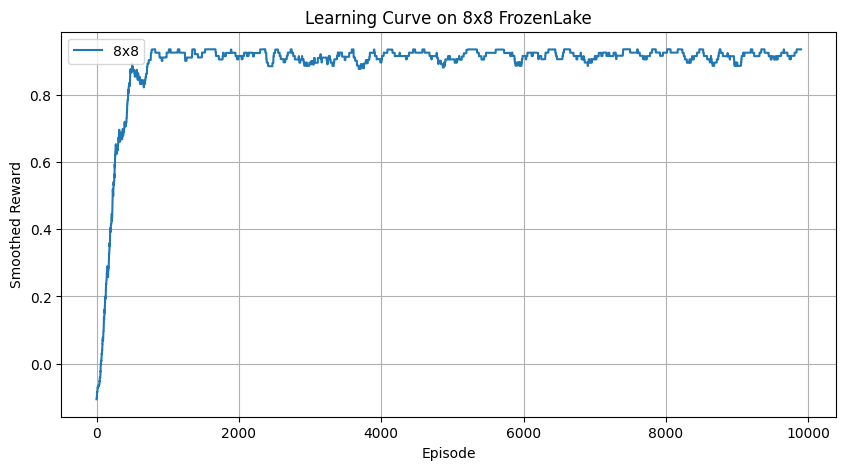

In [ ]:
# figure 39
plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards_8x8, np.ones(100)/100, mode='valid'), label="8x8")
plt.title("Learning Curve on 8x8 FrozenLake")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.show()

In [1621]:
def print_full_q_table(agent, shape):
    for s in range(shape[0] * shape[1]):
        if s in agent.Q:
            row, col = divmod(s, shape[1])
            print(f"State ({row}, {col}) | Q-values: {agent.Q[s]}")


In [ ]:
# figure 40
print_full_q_table(agent_8x8, shape=(8, 8))
# print_full_q_table(agent_16x16, shape=(16, 16)) # too long

State (0, 0) | Q-values: {0: 0.42506507749421213, 1: 0.4646762916074504, 2: 0.4468968671475586, 3: 0.4317980921407614}
State (0, 1) | Q-values: {0: 0.0731479691495689, 1: 0.4938150136591965, 2: 0.12801551133702718, 3: 0.11986489295438225}
State (0, 2) | Q-values: {0: 0.07843991134286449, 1: 0.5154377115704072, 2: 0.055951394983773425, 3: 0.10586815281882711}
State (0, 3) | Q-values: {0: 0.019774486138909437, 1: 0.13054505024229848, 2: 0.5439965826161638, 3: 0.0605584545822173}
State (0, 4) | Q-values: {0: 0.08449456154558906, 1: 0.5929779701470229, 2: 0.08653941679254618, 3: 0.24232660057304634}
State (0, 5) | Q-values: {0: 0.2785766564568371, 1: 0.006772522290504822, 2: -0.00045455577320801784, 3: 0.06153188512776831}
State (0, 6) | Q-values: {0: 0.014103718873313019, 1: 0.11736882882270115, 2: -0.0010949049572666423, 3: 0.008816424940487459}
State (0, 7) | Q-values: {0: 0.014514520525702441, 1: -0.0005073022174205345, 2: -0.0024126489471461374, 3: -0.0017745462915865168}
State (1, 0)

In [1623]:
def display_policy_grid(Q, shape):
    arrows = {0: '←', 1: '↓', 2: '→', 3: '↑'}
    grid = np.full(shape, '', dtype=object)
    for s in range(shape[0] * shape[1]):
        if Q[s]:
            best_action = max(Q[s], key=Q[s].get)
            r, c = divmod(s, shape[1])
            grid[r, c] = arrows[best_action]
    print("Policy Grid (best action per state):")
    print(grid)


In [ ]:
# figure 41
display_policy_grid(agent_8x8.Q, shape=(8, 8))

Policy Grid (best action per state):
[['↓' '↓' '↓' '→' '↓' '←' '↓' '←']
 ['→' '→' '→' '→' '↓' '←' '↓' '↓']
 ['↓' '↑' '↑' '←' '→' '→' '↓' '←']
 ['→' '↑' '←' '→' '↑' '←' '↓' '←']
 ['↓' '←' '←' '←' '↑' '→' '→' '↓']
 ['←' '←' '←' '↓' '←' '→' '←' '↓']
 ['↓' '↓' '←' '←' '←' '→' '←' '↓']
 ['↑' '↓' '←' '←' '↓' '→' '←' '←']]


In [1625]:
def plot_average_reward_curve(rewards, label=None, window=100, title="Average Reward per Episode"):
    smoothed = np.convolve(rewards, np.ones(window)/window, mode='valid')
    plt.figure(figsize=(10, 5))
    plt.plot(smoothed, label=label)
    plt.title(f"{title}")
    plt.xlabel("Episode")
    plt.ylabel(f"Average Reward (window={window})")
    if label:
        plt.legend()
    plt.grid(True)
    plt.show()

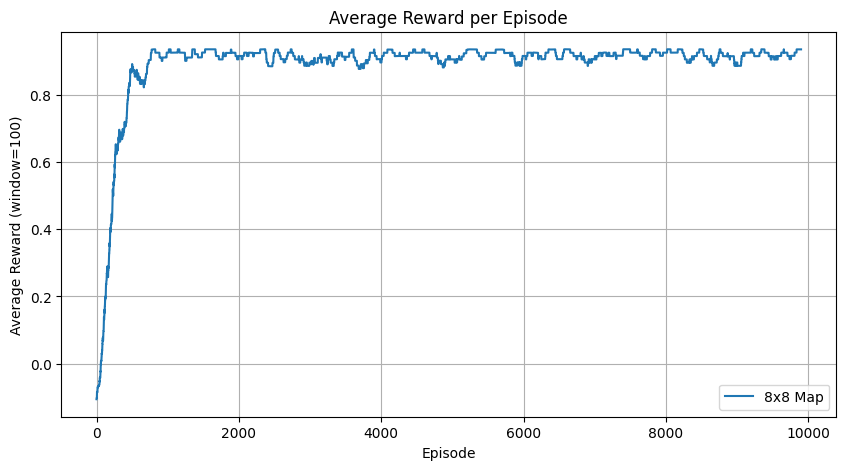

In [ ]:
# figure 42
plot_average_reward_curve(rewards_8x8, label="8x8 Map", window=100)


In [1627]:
# trajectory_16x16 = []

# for i in range(15):
#     trajectory_16x16.append((i * 16, 1, -0.01, (i + 1) * 16, False))

# for j in range(15):
#     current = 15 * 16 + j
#     trajectory_16x16.append((current, 2, -0.01 if j < 14 else 1.0, current + 1, j == 14))


In [ ]:
trajectory_16x16 = [
    (0, 1, -0.01, 16, False),    
    (16, 1, -0.01, 32, False),   
    (32, 2, -0.01, 33, False),   
    (33, 2, -0.01, 34, False),
    (34, 2, -0.01, 35, False),
    (35, 1, -0.01, 51, False),   
    (51, 1, -0.01, 67, False),   
    (67, 1, -0.01, 83, False),   
    (83, 1, -0.01, 99, False),
    (99, 2, -0.01, 100, False),  
    (100, 2, -0.01, 101, False),
    (101, 2, -0.01, 102, False),
    (102, 2, -0.01, 103, False),
    (103, 2, -0.01, 104, False),
    (104, 2, -0.01, 105, False),
    (105, 2, -0.01, 106, False),
    (106, 2, -0.01, 107, False),
    (107, 1, -0.01, 123, False),
    (123, 1, -0.01, 139, False),
    (139, 2, -0.01, 140, False),
    (140, 2, -0.01, 141, False),
    (141, 2, -0.01, 142, False),
    (142, 2, -0.01, 143, False),
    (143, 2, -0.01, 144, False),
    (144, 2, -0.01, 145, False),
    (145, 2, -0.01, 146, False),
    (146, 2, -0.01, 147, False),
    (147, 2, -0.01, 148, False),
    (148, 2, -0.01, 149, False),
    (149, 2, -0.01, 150, False),
    (150, 2, -0.01, 151, False),
    (151, 2, -0.01, 152, False),
    (152, 2, -0.01, 153, False),
    (153, 2, -0.01, 154, False),
    (154, 2, -0.01, 155, False),
    (155, 2, -0.01, 156, False),
    (156, 2, -0.01, 157, False),
    (157, 2, -0.01, 158, False),
    (158, 2, 1.0, 159, True)      
]


In [1629]:
env_16x16 = create_large_env(16, is_slippery=False)
agent_16x16 = QLearningAgent(env_16x16.observation_space.n, env_16x16.action_space.n, **scaling_config)
inject_trajectory(agent_16x16, trajectory_16x16, repetitions=1000)
rewards_16x16 = train_large_with_penalties(env_16x16, agent_16x16, step_penalty=-0.01, hole_penalty=-2.0, episodes=10000)

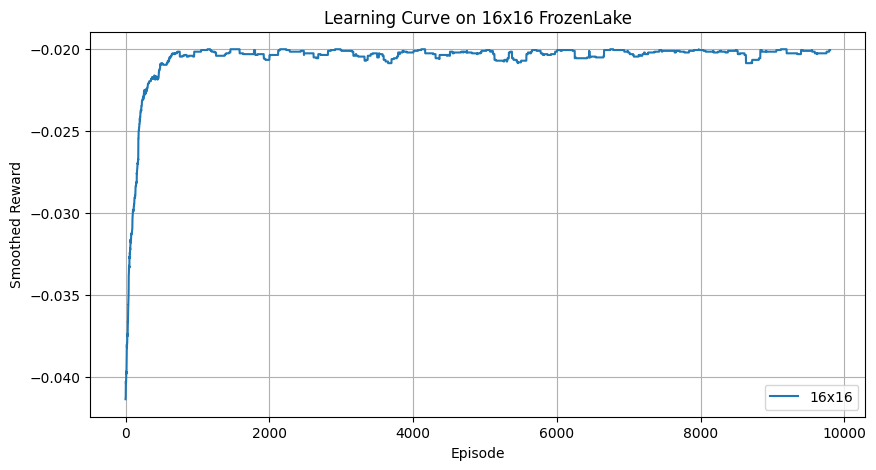

In [ ]:
# figure 43
plt.figure(figsize=(10, 5))
plt.plot(np.convolve(rewards_16x16, np.ones(200)/200, mode='valid'), label="16x16")
plt.title("Learning Curve on 16x16 FrozenLake")
plt.xlabel("Episode")
plt.ylabel("Smoothed Reward")
plt.legend()
plt.grid(True)
plt.show()


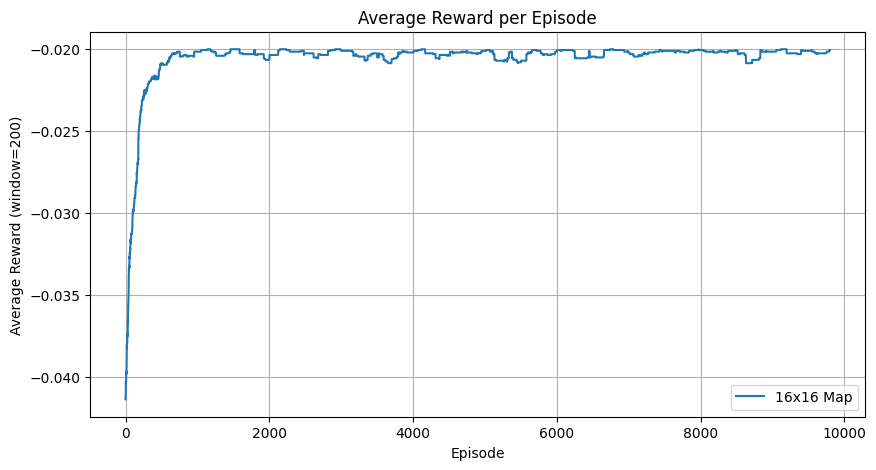

In [ ]:
# figure 44
plot_average_reward_curve(rewards_16x16, label="16x16 Map", window=200)

In [1632]:
def record_video_adv(env, q_table, path="frozenlake_agent.mp4", max_steps=300):
    import imageio
    from IPython.display import Video

    frames = []
    state, _ = env.reset()

    for _ in range(max_steps):
        frame = env.render()
        frames.append(frame)

        if state in q_table and any(abs(v) > 1e-4 for v in q_table[state].values()):
            action = max(q_table[state], key=q_table[state].get)
        else:
            action = env.action_space.sample()

        state, reward, terminated, truncated, _ = env.step(action)
        if terminated or truncated:
            frames.append(env.render())
            break

    imageio.mimsave(path, frames, fps=1)
    return Video(path)


In [1633]:
env_vid = create_large_env(8, is_slippery=False, render_mode="rgb_array")
video = record_video_adv(env_vid, agent_8x8.Q, path="frozenlake_8x8_fixed.mp4", max_steps=300)
video 

In [1634]:
env_vid_l = create_large_env(16, is_slippery=False, render_mode="rgb_array")
video_l = record_video_adv(env_vid_l, agent_16x16.Q, path="frozenlake_16x16_fixed.mp4", max_steps=300)
video_l